In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import classifiers.classifier as classifier
import seaborn as sns
import standard_sequences.rabi_tomo as tomo
import analysis.analysis as analysis

In [2]:
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)

Qubit(ef_amp=1.5, ge_amp=0.874, ef_time=49, qubit_id=q1, qubit_thr=[-10000, -600], RO_LO=6.6247, ge_time=81, ro_amp=1, ro_freq=6.72739, ge_ssm=-0.1144, ef_ssm=-0.2568, RO_IF=None, ROIF=0.10268999999999995, ro_dur=5000, IQ_angle=205, RO_LO_pwr=16)
Qubit(ef_amp=1, ge_amp=0.82, ef_time=None, qubit_id=q2, qubit_thr=[-10000, 1900], RO_LO=6.6247, ge_time=45, ro_amp=1.5, ro_freq=6.65554, ge_ssm=-0.154, ef_ssm=-0.2962, RO_IF=None, ROIF=0.030840000000000423, ro_dur=5000, IQ_angle=85, RO_LO_pwr=16)


In [3]:
def run_rabi_tomo(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    J: float,
    y_ph: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    tomo.rabi_ef_swap_tomo(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        drive_amp_J=J,
        tomo_comp=tomography,
        y_ph=y_ph,
    )

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values

In [4]:
reps = 2000
sweep_time = 250
swap_freq = -0.0194
swap_time = 0.5 * 7 / abs(swap_freq)
J = 35
num_steps = 51
tomography = "y"
y_ph = 90
df_prob, df_pop, values = run_rabi_tomo(
    q1=q1,
    q2=q2,
    general_vals_dict=general_vals_dict,
    num_steps=num_steps,
    sweep_time=sweep_time,
    swap_freq=swap_freq,
    swap_time=swap_time,
    reps=reps,
    tomography=tomography,
    J=J,
    y_ph=y_ph,
)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 14.210105 sec
Captured 34 buffers (2.392663 buffers per sec)
Captured 104448 records (7350.262149 records per sec)
Transferred 1711276032 bytes (120426695.054123 bytes per sec)


In [5]:
# def run_rabi_y_tomo_swap_freq_sweep(freq_list, filename="rabi_y_tomo_swap_freq_sweep.pkl"):
#     """
#     Run a Rabi tomography sweep at different swap frequencies.
#     Save results to a file after each step. If the file already exists, restart from the last completed step.
#     """
#     reps = 2000
#     sweep_time = 300
#     num_steps = 51
#     tomography = 'y'
#     y_ph = 65

#     # Initialize arrays to store results
#     df_prob_list = []

#     # Check if the file exists
#     if os.path.exists(filename):
#         print(f"Loading existing data from {filename}...")
#         with open(filename, "rb") as f:
#             saved_data = pickle.load(f)

#         # Load saved data
#         df_prob_list = saved_data["df_prob_list"]
#         last_completed_step = saved_data["last_completed_step"]

#         print(f"Resuming from step {last_completed_step + 1}/{len(freq_list)}")
#     else:
#         last_completed_step = -1  # Start from the beginning

#     # Run the sweep
#     for i in range(last_completed_step + 1, len(freq_list)):
#         freq = freq_list[i]
#         swap_freq = freq
#         swap_time = 0.5 * 6 / abs(swap_freq)

#         # Perform Rabi tomography experiment
#         df_prob, df_pop, values = run_rabi_tomo(
#             q1=q1,
#             q2=q2,
#             general_vals_dict=general_vals_dict,
#             num_steps=num_steps,
#             sweep_time=sweep_time,
#             swap_freq=swap_freq,
#             swap_time=swap_time,
#             reps=reps,
#             tomography=tomography,
#             J=35,
#             y_ph=y_ph
#         )

#         # Store results
#         df_prob_list.append(df_prob)

#         # Save results to file after each step
#         with open(filename, "wb") as f:
#             pickle.dump(
#                 {
#                     "freq_list": freq_list,
#                     "df_prob_list": df_prob_list,
#                     "last_completed_step": i,  # Track the last completed step
#                 },
#                 f,
#             )

#         print(f"------------- Done with {i+1}/{len(freq_list)} --------------------")

#     return df_prob_list

In [6]:
# freq = -0.0195
# freq_diff = 0.003
# steps = 101
# freq_list = np.linspace(freq - freq_diff, freq + freq_diff, steps)
# df_prob_list = run_rabi_y_tomo_swap_freq_sweep(freq_list)

In [7]:
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # Define the sine function for fitting
# def sine_function(x, A, phi, offset):
#     return A * np.sin(2 * np.pi * x + phi) + offset

# # Load the saved data
# filename = "rabi_y_tomo_swap_freq_sweep.pkl"
# with open(filename, "rb") as f:
#     saved_data = pickle.load(f)

# freq_list = saved_data["freq_list"]
# df_prob_list = saved_data["df_prob_list"]

# # Initialize a list to store y-amplitudes from sine fit
# y_amplitudes = []

# # Loop through each frequency and corresponding df_prob
# for freq, df_prob in zip(freq_list, df_prob_list):
#     # Extract time, P_f, and P_e
#     time = df_prob['time']
#     P_f = df_prob['P_f']
#     P_e = df_prob['P_e']

#     # Normalize P_f and P_e by dividing by (P_f + P_e)
#     epsilon = 1e-10  # Small value to avoid division by zero
#     P_f_normalized = P_f / (P_f + P_e + epsilon)
#     P_e_normalized = P_e / (P_f + P_e + epsilon)

#     # Fit P_f_normalized to a sine function
#     try:
#         popt, _ = curve_fit(sine_function, time, P_f_normalized, p0=[0.5, 0, 0.5])
#         amplitude = popt[0]  # Extract amplitude from the fit
#     except RuntimeError:
#         print(f"Failed to fit sine function for frequency = {freq:.6f}")
#         amplitude = np.nan  # Use NaN if fitting fails

#     # Store the y-amplitude
#     y_amplitudes.append(amplitude)

# # Plot frequency vs y-amplitude
# plt.figure(dpi=150)
# plt.plot(freq_list, y_amplitudes, 'o-', label='Y-Amplitude (Sine Fit)')
# plt.xlabel('Swap Frequency')
# plt.ylabel('Y-Amplitude')
# plt.axvline(-.0195, ls = 'dashed', color = 'red', label = 'Current Swap Frequency')
# plt.title('Frequency vs Y-Amplitude (Sine Fit)')
# plt.grid()
# plt.show()

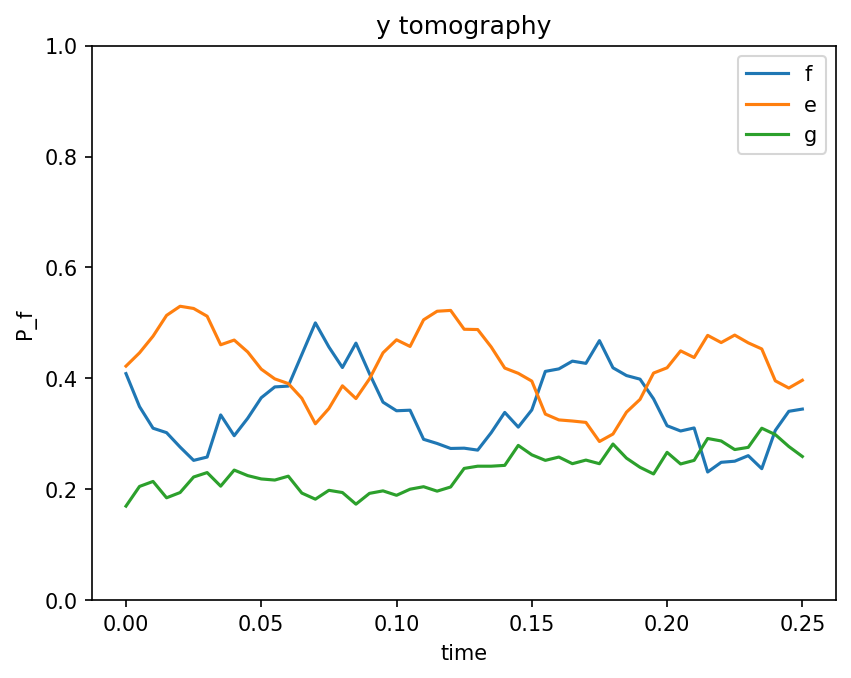

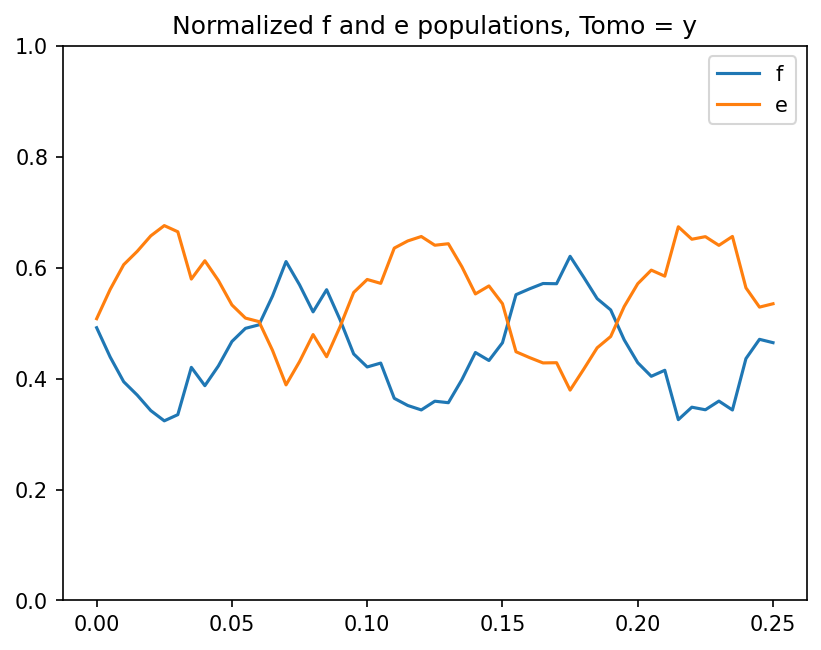

In [8]:
plt.figure(dpi=150)
sns.lineplot(data=df_prob, x="time", y="P_f", label="f")
sns.lineplot(data=df_prob, x="time", y="P_e", label="e")
sns.lineplot(data=df_prob, x="time", y="P_g", label="g")
plt.title(f"{tomography} tomography")
plt.legend()
plt.ylim(0, 1)
plt.show()
plt.figure(dpi=150)
normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])
sns.lineplot(data=normalized_f, label="f")
sns.lineplot(data=normalized_e, label="e")
plt.title(f"Normalized f and e populations, Tomo = {tomography}")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [9]:
# Define the list of y_ph values to sweep over
y_ph_list = np.linspace(15, 85, 41)  # Example list, replace with your actual values

reps = 2000
sweep_time = 250
swap_freq = -0.0195
swap_time = 0.5 * 6 / abs(swap_freq)
J = 35
num_steps = 51
tomography = "y"
# Define the folder to save results
save_folder = "y_ph_sweep"
os.makedirs(save_folder, exist_ok=True)

# Define a checkpoint file to track progress
checkpoint_file = os.path.join(save_folder, "checkpoint.txt")

# Load the last completed y_ph value if the checkpoint file exists
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, "r") as f:
        last_completed_y_ph = float(f.read().strip())
else:
    last_completed_y_ph = None

# Loop over the y_ph values
for y_ph in y_ph_list:
    # Skip already completed y_ph values
    if last_completed_y_ph is not None and y_ph <= last_completed_y_ph:
        print(f"Skipping y_ph = {y_ph} (already completed)")
        continue

    print(f"Running for y_ph = {y_ph}")

    # Run the Rabi tomography simulation
    df_prob, df_pop, values = run_rabi_tomo(
        q1=q1,
        q2=q2,
        general_vals_dict=general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        reps=reps,
        tomography=tomography,
        J=J,
        y_ph=y_ph,
    )

    # Save the df_prob dataframe
    save_filename = os.path.join(save_folder, f"df_prob_y_ph_{y_ph}.csv")
    df_prob.to_csv(save_filename, index=False)
    print(f"Saved results for y_ph = {y_ph} to {save_filename}")

    # Update the checkpoint file
    with open(checkpoint_file, "w") as f:
        f.write(str(y_ph))
    print(f"Updated checkpoint to y_ph = {y_ph}")

print("Sweep complete!")

Skipping y_ph = 15.0 (already completed)
Skipping y_ph = 16.75 (already completed)
Skipping y_ph = 18.5 (already completed)
Skipping y_ph = 20.25 (already completed)
Skipping y_ph = 22.0 (already completed)
Skipping y_ph = 23.75 (already completed)
Skipping y_ph = 25.5 (already completed)
Skipping y_ph = 27.25 (already completed)
Skipping y_ph = 29.0 (already completed)
Skipping y_ph = 30.75 (already completed)
Skipping y_ph = 32.5 (already completed)
Skipping y_ph = 34.25 (already completed)
Skipping y_ph = 36.0 (already completed)
Skipping y_ph = 37.75 (already completed)
Skipping y_ph = 39.5 (already completed)
Skipping y_ph = 41.25 (already completed)
Skipping y_ph = 43.0 (already completed)
Skipping y_ph = 44.75 (already completed)
Skipping y_ph = 46.5 (already completed)
Skipping y_ph = 48.25 (already completed)
Skipping y_ph = 50.0 (already completed)
Skipping y_ph = 51.75 (already completed)
Skipping y_ph = 53.5 (already completed)
Skipping y_ph = 55.25 (already completed)
Skip